In [1]:
import scipy
import os
import numpy as np, pandas as pd, matplotlib.pyplot as plt

In [2]:
#set the directory to the data file
current_dir = os.getcwd()
os.chdir('c:\\Users\\Melanie\\OneDrive - Rensselaer Polytechnic Institute\\Desktop\\School\\24_Spring\\MLE\\Project\\data')

electrode_locations = {"FP1": 0, "FP2": 1, "FC5": 2, "FC6": 3, "FZ": 4,
                        "T7": 5, "CZ": 6, "T8": 7, "P7": 8, "P3": 9, "PZ": 10,
                          "P4": 11, "P8": 12, "O1": 13, "Oz": 14, "O2": 15}

files = os.listdir()

#getting the demographics both gets rid   
demographics = pd.read_csv(files.pop(0),names=["Isman","Age","Fatigue"])

#### Making the plot just for the timed segments

In [5]:
def plot_signal(section_num, t, signal, class_bool, title_text):
    colors = ["r","g"]
    n = np.shape(signal)[0]
    fig, axs = plt.subplots(nrows=n,figsize=(8,n*0.5))
    for i in range(n):
        #plotting the colors
        for j in range(1,int(max(section_num))):
            indices = np.where(section_num == j)
            class_boolean = int(class_bool[indices[0]][0])
            axs[i].plot(t[indices],signal[i][indices],colors[class_boolean%2])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    fig.suptitle(title_text)
    plt.tight_layout()
    plt.show()

#### DATA CLEANING TIME

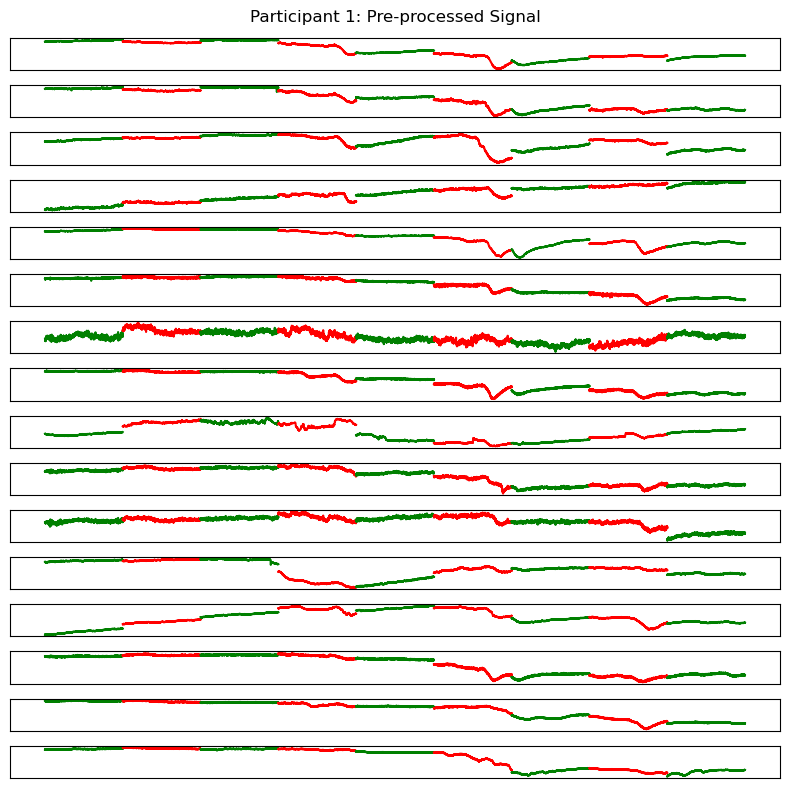

In [6]:
def extract_segments(participant):
    """Gets just the segments where the subject is being tested
    Input:  participant - the file name
    Output: t           - 
            signal      -
            section_num -
            colors      - the graph colors """

    #get the signal
    signal = scipy.io.loadmat(participant)["SIGNAL"].T
    n,m = np.shape(signal)
    booleans = signal[-2:] #get the columns that show where is what

    #getting the starting indices. np.nonzero returns two arrays, one for the values,
    #and the other one for the locations. Using this I can already get the classes
    # and the indices
    indices = np.nonzero(booleans)
    sort_indices = np.argsort(indices[1])

    classes = indices[0][sort_indices]
    indices = indices[1][sort_indices]

    #now making two arrays, one for the section number and the other for the class boolean
    class_bool = np.zeros(m) 
    section_num = np.zeros(m)

    for (s_num,ind),cond in zip(enumerate(indices),classes):
        class_bool[ind:ind+5121] = cond+1
        section_num[ind:ind+5121] = s_num+1
    
    # choosing only the test condition times
    test_indices = np.where(section_num != 0)[0]
    trimmed_signal = signal.T[test_indices].T

    #splitting up the data
    t = np.array(list(range(len(test_indices))))*0.001953125
    signal = trimmed_signal[1:-2]
    section_num = section_num[test_indices]
    class_bool = class_bool[test_indices]

    #getting the participant number
    p_number = int(files[0].split(".")[0].split("_")[1])

    return t, signal, section_num, class_bool, p_number

t, signal, section_num, class_bool, p_num = extract_segments(files[0])

title_text = "Participant {}: Processed Signal".format(p_num)
plot_signal(section_num, t, signal, class_bool, title_text)

### Whiten the data first using PCA

In [80]:
from sklearn.decomposition import PCA

In [96]:
"""I wonder why the dimensions are so low for some of the participants"""
pca = PCA(whiten = True, n_components = 0.99) #whiten means making mean = 0, sd = 1

for f in files:
    t, signal, section_num, class_bool, p_num = extract_segments(f)

    new_signal = pca.fit_transform(signal.T).T

    print(np.shape(new_signal)[0])

6
3
8
5
5
3
7
3
4
4
9
4
2
3
4
3
3
3
6
4


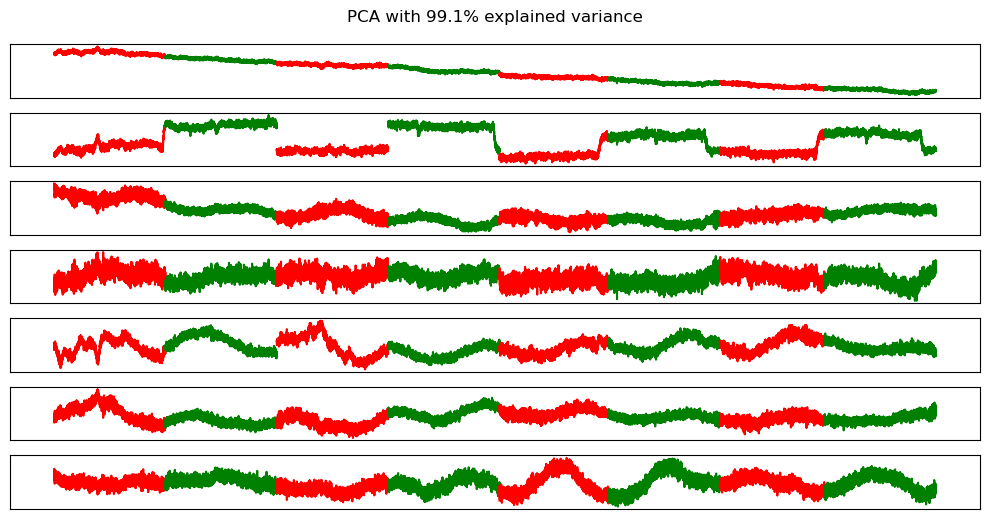

In [46]:
pca = PCA(whiten = True, n_components = 0.99)
new_signal = pca.fit_transform(signal.T).T
title_text = "PCA with {:.1f}% explained variance".format(np.sum(pca.explained_variance_ratio_*100))
plot_signal(section_num, t, new_signal, colors, title_text)

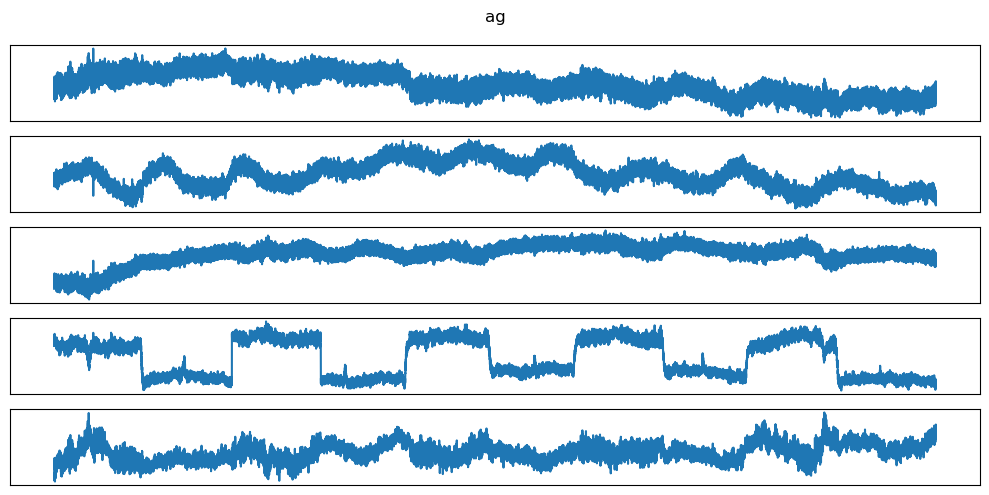

In [25]:
from sklearn.decomposition import FastICA
"""Independent Component Analysis"""
n = 5
transformer = FastICA(n_components = n, 
        random_state = 420)
new_new_signal = transformer.fit_transform(new_signal).T

fig, axs = plt.subplots(nrows=n,figsize=(10,n))
for i in range(n):
    #plotting the colors
    axs[i].plot(t,new_new_signal[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
fig.suptitle("ag")
plt.tight_layout()
plt.show()

#